In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# move into project directory
repo_name = "UMass-CS670-Project"
%cd /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name
!ls

/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project
common			  get_dataset.sh	   models		  source-data
config.yaml		  get_info.py		   preprocess_dataset.py  test_seg.py
datautils		  github-repo-clone.ipynb  README.md		  texture_params.txt
demo			  Index.ipynb		   SINet.ipynb
excluded-train-files.txt  index.py		   sinet.py
experiments		  last_run_info.json	   SINet_r18.ipynb


In [ ]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'''
!pip install grad-cam
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
'''

#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!sudo mv sam_vit_h_4b8939.pth /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name/models/weights/sam_vit_h_4b8939.pth


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [ ]:
#!unzip -qq ./source-data/TestDataset.zip -d ./source-data/

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# uncomment the lines below  to download the data

import os

!pip install gdown

data_dir="source-data"

if not(os.path.exists("source-data")):
    !gdown https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL&export=download
    #echo 'Downloaded data! Unzipping to data folder'
    !unzip -qq -d . ./COD10K-v3.zip
    os.rename("./COD10K-v3.zip", "./source-data/COD10K-v3.zip")
else:
    print("\nThe data directory exists!")

Downloading...
From (original): https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL
From (redirected): https://drive.google.com/uc?id=1IAd2b7EtPqqXbFF3D9PLsHCDjMnr9UkL&confirm=t&uuid=c667282e-3fa7-4b49-ad05-110b414ad71c
To: /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/COD10K-v3.zip
100% 2.38G/2.38G [01:29<00:00, 26.6MB/s]


In [ ]:
# setup some imports
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
import argparse
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import json

from experiments.style_transfer import style_transfer, run_style_transfer_pipeline, deep_style_transfer
from common.visualizer import layer_visualizer
from common.utils import init_config

In [ ]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
config_params = init_config()
print(config_params)

{'data_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/source-data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/output', 'root_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project', 'use_gpu': True}


In [53]:
import torch
from models.ots_models import get_model
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io
from torchvision.io import read_image
from common.utils import convert_to_grascale, get_transforms, get_config
import json
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import matplotlib.pyplot as plt
from common.sam_utils import show_mask, show_box
import numpy as np
from common.closed_form_matting import closed_form_matting_with_mask
import torch.nn.functional as F

CHECKPOINT_PATH='./models/weights/sam_vit_h_4b8939.pth'

MODEL_TYPE = "vit_h"


def __get_gram_matrix(features):
    n,c,h,w = features.size()
    features = torch.reshape(features, (n, c, h*w))
    G = torch.matmul(features, features.transpose(1, 2))
    G /= (h * w * c)
    return G

def __content_loss(content_weight, curr_content, orig_content):
    return content_weight * torch.sum((curr_content - orig_content)**2)

def __augmented_style_loss(features, style_layers, style_grams, style_weights, content_mask):
    cfg = get_config()
    if torch.cuda.is_available():
        stloss = torch.tensor(0.0).to('cuda')
    else:
        stloss = torch.tensor(0.0)

    scaled_mask = content_mask.to(cfg['device'])
    #scaled_mask.to(cfg['device'])
    for i in range(len(style_layers)):
        stlyr = features[style_layers[i]].clone()
        stlyr = stlyr * scaled_mask
        gm = __get_gram_matrix(stlyr)
        N = torch.numel(gm) ** 2
        #print(type(N))
        #stloss += (style_weights[i] * torch.sum((style_grams[i] - gm)**2))a
        #print(style_grams[i].size(), gm.size())
        stloss += (0.5 * (1 / N) * (torch.sum((gm - style_grams[i])**2, (1, 2))))[0]
        scaled_mask = F.interpolate(scaled_mask, scale_factor = 0.5, mode = 'bilinear', antialias = False)

    return stloss


def __style_loss(features, style_layers, style_grams, style_weights):

    if torch.cuda.is_available():
        stloss = torch.tensor(0.0).to('cuda')
    else:
        stloss = torch.tensor(0.0)

    for i in range(len(style_layers)):
        stlyr = features[style_layers[i]].clone()
        gm = __get_gram_matrix(stlyr)
        stloss += (style_weights[i] * torch.sum((style_grams[i] - gm)**2))

    return stloss

def __tv_loss(img, tv_weight):
    _, _, h, w = img.size()
    lt = torch.sum((img[:, :, 1:h, :] - img[:, :, :h-1, :])**2)
    rt = torch.sum((img[:, :, :, 1:w] - img[:, :, :, :w-1])**2)
    tvloss = tv_weight * (lt + rt)
    return tvloss

def __get_features(img, model_features):
    features = []
    x = img

    for _, layer in enumerate(model_features._modules.values()):
        op = layer(x)
        features.append(op)
        x = op

    return features

def __get_mask(np_img):

    cfg = get_config()
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=cfg['device'])
    mask_generator = SamAutomaticMaskGenerator(sam)

    #plt.imshow(np_img)
    #plt.show()
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(np_img)
    w, h, _ = np_img.shape
    #print(image_rgb.shape)


    # Predict mask with bounding box prompt
    bbox_prompt = np.array([0, 0, h, w])
    masks, scores, logits = mask_predictor.predict(
    box=bbox_prompt,
    multimask_output=False
    )

    # Plot the bounding box prompt and predicted mask
    #plt.imshow(np_img)
    #show_mask(masks[0], plt.gca())
    #show_box(bbox_prompt, plt.gca())
    #plt.show()

    #plt.imshow(masks[0], cmap='binary')
    #plt.show()

    return masks[0]

def __get_tensor_from_sparse_scipy(scipy_sparse_matrix):

    cfg = get_config()

    data = torch.tensor(scipy_sparse_matrix.data, dtype = torch.float32)
    col = torch.tensor(scipy_sparse_matrix.col, dtype = torch.long)
    row = torch.tensor(scipy_sparse_matrix.row, dtype = torch.long)
    indices = torch.stack([row, col])

    i = torch.LongTensor(indices)
    shape = scipy_sparse_matrix.shape

    return torch.sparse_coo_tensor(indices, data, shape)
    #return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

def deep_style_transfer(content_img, style_img, style_layers, content_layer, content_weight, style_weights, lamda, eta, args):

    cfg = get_config()

    og_content_img = content_img
    og_style_img = style_img

    np_style_img = style_img.transpose(0, 2).transpose(0, 1).numpy()
    np_content_img = content_img.transpose(0, 2).transpose(0, 1).numpy()
    style_mask = __get_mask(np_style_img)
    content_mask = __get_mask(np_content_img)
    content_mask_bg = (content_mask == 1).astype(float)
    style_mask_bg = (style_mask == 1).astype(float)
    content_img_bg = np_content_img * np.expand_dims(content_mask_bg, 2)
    style_img_bg = np_style_img * np.expand_dims(style_mask_bg, 2)
    #plt.imshow(content_img_bg/255.0)
    #plt.show()
    #Mc = closed_form_matting_with_mask(np_content_img, content_mask)
    Mc = closed_form_matting_with_mask(content_img_bg, content_mask)
    Mc = __get_tensor_from_sparse_scipy(Mc).to(cfg['device'])
    #print('images', np_style_img.shape, np_content_img.shape, style_mask.shape, content_mask.shape)
    #print('laplacians', Mc.size(), type(Mc))
    #style_mask = torch.from_numpy(style_mask)[None, None, :].float()
    #content_mask = torch.from_numpy(content_mask)[None, None, :].float()
    style_mask_bg = torch.from_numpy(style_mask_bg)[None, None, :].float()
    content_mask_bg = torch.from_numpy(content_mask_bg)[None, None, :].float()
    style_img = torch.from_numpy(style_img_bg).transpose(2, 0).transpose(2, 1)
    content_img = torch.from_numpy(content_img_bg).transpose(2, 0).transpose(2, 1)
    #print('content sizes', style_img.size(), content_img.size(), og_content_img.size(), og_style_img.size())
    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        device = 'cuda'
    else:
        dtype = torch.FloatTensor
        device = 'cpu'

    model, _ = get_model(args.model_name, True)
    model_features = model.features
    model_features.type(dtype)

    for param in model_features.parameters():
        param.requires_grad = False

    style_img = style_img.type(dtype) #read_image('./data/Textures/tree-bark.jpg').type(dtype)
    content_img = content_img.type(dtype) #read_image('./data/Mini-Set/butterfly-image.jpg').type(dtype)
    #print('img sizes', style_img.size(), content_img.size())
    c_transform, c_inv_transform = get_transforms()
    content_img = c_transform(content_img)
    #print('cs after', content_img.shape)
    features = __get_features(content_img, model_features)
    content_trgt = features[content_layer].clone()

    s_transform, _ = get_transforms()
    style_img = s_transform(style_img)[None]
    style_features = __get_features(style_img, model_features)
    #style_mask_features = __get_features()
    style_grams = []

    scaled_style_mask = style_mask_bg.to(cfg['device'])
    #scaled_style_mask.to(cfg['device'])
    for i in style_layers:
        fm = style_features[i].clone() * scaled_style_mask
        stg = __get_gram_matrix(fm)
        #print('style layers: ', i, stg.size(), features[i].size())
        style_grams.append(stg)
        scaled_style_mask = F.interpolate(scaled_style_mask, scale_factor = 0.5, mode = 'bilinear', antialias = False)

    new_img = content_img[None, :].clone().type(dtype)
    new_img.requires_grad_(True)
    #print('ns', new_img.shape)
    optimizer = torch.optim.Adam([new_img], lr = args.lr)

    losses = []
    closses = []
    tlosses = []
    slosses = []

    for t in range(args.max_iter):
        #if t < (args.max_iter - 10):
        new_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        features = __get_features(new_img, model_features)
        closs = __content_loss(content_weight, features[content_layer], content_trgt)
        #sloss = __style_loss(features, style_layers, style_grams, style_weights)
        sloss = __augmented_style_loss(features, style_layers, style_grams, style_weights, content_mask_bg)
        #print('augmented style loss', sloss.size())
        #tloss = __tv_loss(new_img, tv_weight)
        loss = closs + (eta * sloss) #+ tloss
        losses.append(loss.cpu().detach().numpy())
        closses.append(closs.cpu().detach().numpy())
        #tlosses.append(tloss.cpu().detach().numpy())
        slosses.append(sloss.cpu().detach().numpy())
        #print('loss grad', loss.requires_grad)
        loss.backward()
        optimizer.step()

        img_vec = new_img.reshape(-1, 3).transpose(0, 1)
        #print('img vec', img_vec.size(), Mc.size(), img_vec.get_device(), Mc.get_device())
        dotsum = 0
        preg_grad = torch.zeros(img_vec.size()).T.to(cfg['device'])
        for i in range(3):
            im_row = img_vec[i, :][None, :]
            grad = torch.sparse.mm(Mc, im_row.T)
            #print('grad size', grad.size())
            preg_grad += grad
            dotprod = torch.einsum('ij,jk->i', img_vec, grad)
            dotsum += dotprod[0]
        ploss = lamda * dotsum
        preg_grad = 2 * preg_grad
        preg_grad = preg_grad.reshape(new_img.size())
        #print('preg', preg_grad.size(), ploss.size(), new_img.grad.size())
        loss += ploss
        new_img.grad += preg_grad

        if t % args.iter_interval == 0:
            print('\n\nIteration {}'.format(t))
            plt.axis('off')
            print('Losses: ', closs.item(), sloss.item(), loss.item())
            #print(new_img.data.size(), t)
            rescaled_img = c_inv_transform(new_img.data.cpu())
            #print(rescaled_img.size())
            rescaled_img = rescaled_img.transpose(0, 2).transpose(0, 1)
            #print(rescaled_img.size())
            plt.imshow(rescaled_img)
            plt.show()

    rescaled_img = c_inv_transform(new_img.data.cpu())
    #print('og sizes', content_mask_bg.size(), og_content_img.size(), rescaled_img.size())
    rescaled_img = (rescaled_img * content_mask_bg[0]) + ((og_content_img/255.0) * (1 - content_mask_bg[0]))
    rescaled_img = rescaled_img.transpose(0, 2).transpose(0, 1)
    new_img = new_img.detach().cpu()
    style_img = style_img.cpu()
    content_img = content_img.cpu()
    del style_img, content_img, new_img


    print('\n\nIteration {}'.format(t))
    plt.axis('off')
    print('Losses: ', closs.item(), sloss.item(), loss.item())
    plt.imshow(rescaled_img)
    plt.show()

    '''
    print('\n\n\n Loss plots')
    plt.clf()
    plt.plot(list(range(args.max_iter)), losses, color='b')
    plt.plot(list(range(args.max_iter)), closses, color='r')
    plt.plot(list(range(args.max_iter)), slosses, color='g')
    plt.plot(list(range(args.max_iter)), tlosses, color='y')
    plt.legend(['Total loss', 'Content loss', 'Style loss', 'Total variation loss'])
    plt.show()
    '''


def style_transfer(content_img, style_img, style_layers, content_layer, content_weight, style_weights, tv_weight, args):

    if torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
        device = 'cuda'
    else:
        dtype = torch.FloatTensor
        device = 'cpu'

    model, _ = get_model(args.model_name, True)
    model_features = model.features
    model_features.type(dtype)

    for param in model_features.parameters():
        param.requires_grad = False

    style_img = style_img.type(dtype) #read_image('./data/Textures/tree-bark.jpg').type(dtype)
    content_img = content_img.type(dtype) #read_image('./data/Mini-Set/butterfly-image.jpg').type(dtype)
    #print('img sizes', style_img.size(), content_img.size())
    c_transform, c_inv_transform = get_transforms()
    content_img = c_transform(content_img)
    #print('cs after', content_img.shape)
    features = __get_features(content_img, model_features)
    content_trgt = features[content_layer].clone()

    s_transform, _ = get_transforms()
    style_img = s_transform(style_img)[None]
    features = __get_features(style_img, model_features)
    style_grams = []

    for i in style_layers:
        style_grams.append(__get_gram_matrix(features[i].clone()))

    new_img = content_img.clone().type(dtype)
    new_img.requires_grad_(True)
    #print('ns', new_img.shape)
    optimizer = torch.optim.Adam([new_img], lr = args.lr)

    losses = []
    closses = []
    tlosses = []
    slosses = []

    for t in range(args.max_iter):
        #if t < (args.max_iter - 10):
        new_img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()
        features = __get_features(new_img, model_features)
        closs = __content_loss(content_weight, features[content_layer], content_trgt)
        sloss = __style_loss(features, style_layers, style_grams, style_weights)
        tloss = __tv_loss(new_img, tv_weight)
        loss = closs + (100* sloss) + tloss
        losses.append(loss.cpu().detach().numpy())
        closses.append(closs.cpu().detach().numpy())
        tlosses.append(tloss.cpu().detach().numpy())
        slosses.append(sloss.cpu().detach().numpy())
        #print('loss grad', loss.requires_grad)
        loss.backward()
        optimizer.step()

        '''
        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            print('Losses: ', closs.item(), sloss.item(), loss.item())
            rescaled_img = c_inv_transform(new_img.data.cpu())
            plt.imshow(rescaled_img)
            plt.show()
        '''

    rescaled_img = c_inv_transform(new_img.data.cpu())
    new_img = new_img.detach().cpu()
    style_img = style_img.cpu()
    content_img = content_img.cpu()
    del style_img, content_img
    '''
    print('Iteration {}'.format(t))
    plt.axis('off')
    print('Losses: ', closs.item(), sloss.item(), loss.item())
    plt.imshow(rescaled_img)
    plt.show()

    print('\n\n\n Loss plots')
    plt.clf()
    plt.plot(list(range(args.max_iter)), losses, color='b')
    plt.plot(list(range(args.max_iter)), closses, color='r')
    plt.plot(list(range(args.max_iter)), slosses, color='g')
    plt.plot(list(range(args.max_iter)), tlosses, color='y')
    plt.legend(['Total loss', 'Content loss', 'Style loss', 'Total variation loss'])
    plt.show()
    '''
    return rescaled_img


def run_style_transfer_pipeline(args,
    texture_name, style_weight, last_batch_run = -1):

    pos_data_paths = read_data('Train')

    dataset = COD10KDataset(pos_data_paths)

    dataloader = DataLoader(dataset, batch_size = args.batch_size, shuffle = False)

    for i_batch, batch in enumerate(dataloader):
        if i_batch > last_batch_run:
            print(f"Processing batch {i_batch}, image: {batch['img_name']} of dimensions: {batch['img'].shape}")
            style_img = read_image(f'./source-data/Textures/{texture_name}.jpg')
            new_img = style_transfer(
                batch['img'],
                style_img,
                [0, 2, 5, 14, 23],
                21,
                1e-4,
                [style_weight]*5,
                1e-5,
                args)
            img_name = batch['img_name'][0]
            img_name = img_name.replace(".jpg", "")
            img_name = f"./source-data/Train/Styled-Image/{img_name}-Texture-{texture_name}.jpg"
            save_image(new_img, img_name)
            last_run = {
                "last_batch": i_batch
            }
            print(f"completing transfer of img {i_batch} with texture {texture_name}")
            with open("./last_run_info.json", "w") as fp:
                json.dump(last_run, fp)

    print(f'Finished modifying train dataset images for {texture_name}')
    last_run = {
        "last_batch": -1
    }
    with open("./last_run_info.json", "w") as fp:
        json.dump(last_run, fp)
    return -1




In [60]:

param_dict = {
    'moss': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'snow': {
        'epochs': 200,
        'style_weights': 1.5
    },
    'wet-sand': {
        'epochs': 200,
        'style_weights': 3.5
    },
    'sand-with-moss': {
        'epochs': 100,
        'style_weights': 2.5
    },
    'rain': {
        'epochs': 100,
        'style_weights': 4.5
    },
    'wood': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'grass': {
        'epochs': 100,
        'style_weights': 0.1
    },
    'foliage-texture': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'blue-coral': {
        'epochs': 100,
        'style_weights': 1.1
    }
}

with open("./last_run_info.json") as fp:
    last_run = json.load(fp)["last_batch"]

selected_textures = ['moss', 'wet-sand', 'sand-with-moss', 'rain', 'foliage-texture']



'''
for texture in selected_textures:

    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type = int, default = 1)
    parser.add_argument('--model_name', type=str, default='vgg')
    parser.add_argument('--lr', type=float, default=0.05)
    parser.add_argument('--max_iter', type=int, default=param_dict[texture]['epochs'])
    args = parser.parse_args(args=[])

    style_img = read_image(f'./source-data/Textures/{texture}.jpg')
    #img = read_image('./source-data/Mini-Set/bgm-bird-1.jpg')
    #print(img.size())
    #layer_visualizer(img, args)

    run_style_transfer_pipeline(args, texture, param_dict[texture]['style_weights'], last_run)
'''

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--max_iter', type=int, default=1000)
parser.add_argument('--iter_interval', type=int, default=100)
args = parser.parse_args(args=[])

style_img = read_image(f'./source-data/Textures/red-sand.jpg')
img = read_image('./source-data/Mini-Set/bgm-bird-2.jpg')
#img = img[None, :]
#print(img.size())
#layer_visualizer(img, args)
#layer_visualizer(style_img, args)
style_layers = [1, 6, 11, 20, 29] #[2]
#style_layers = [0, 2, 5, 14, 23]
content_layer = 22
style_weights = [0.2] * 5 #[1.5]*5
content_weight = 1e-2 #1e-4 #1
#total_variance_weight = 1e-3 #1e-5 4
lamda = 1e6
eta = 1e2
deep_style_transfer(img, style_img, style_layers, content_layer, content_weight, style_weights, lamda, eta, args)


Output hidden; open in https://colab.research.google.com to view.

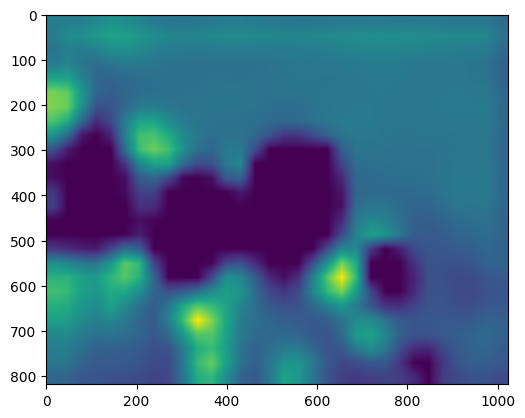

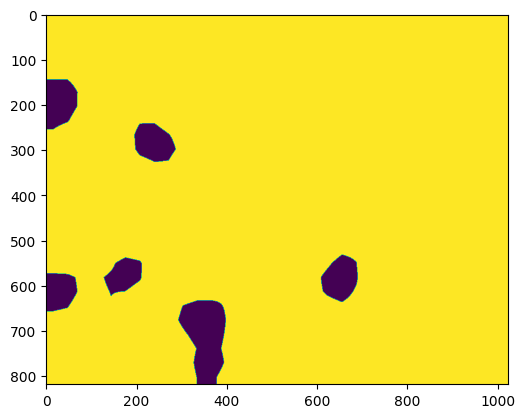

(1, 819, 1023, 3) (819, 1023)


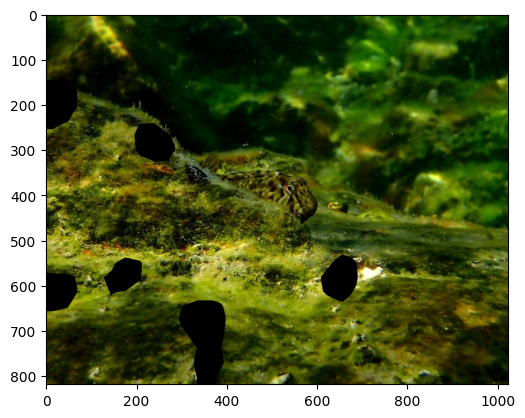

In [48]:
from models.custom_models import get_model
from common.utils import load_model, init_config
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset, CamouflagedTestDataset
import random
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch
import argparse
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from common.utils import get_config
import os
from tqdm import tqdm
#from torchvision.io import read_image
from PIL import Image

class SemanticSegmentation:

    def __init__(self, model_path, model_name, num_classes):
        init_config()
        self.model = get_model(num_classes, model_name)
        mf = load_model(model_path)
        self.model.load_state_dict(mf)

    def __prepare_data(self, dataset_name = 'cod10k'):
        dataset = CamouflagedTestDataset(dataset_name)
        smlen = int(0.1 * len(dataset))
        #ridxs = random.sample(range(len(dataset)), smlen)
        ridxs = list(range(smlen))
        smftr_dataset = Subset(dataset, ridxs)
        return dataset, smftr_dataset

    def __image_collate(self, batch):
        batchlist = list(map(list, zip(*batch)))
        return batchlist

    def __convert_to_grascale(self, img):
        imin, imax = img.min(), img.max()
        x = (img - imin) / (imax - imin)
        return x

    def run(self, args, dataset_name = 'cod10k'):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(self.__convert_to_grascale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        cfg = get_config()

        test_dataset, sm_test_dataset = self.__prepare_data(dataset_name)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn = self.__image_collate)
        target_layers = [self.model.model.layer4[-1]]
        grad_cam = GradCAM(model = self.model.model, target_layers = target_layers)
        target_class = [ClassifierOutputTarget(1)]
        for i_batch, batch in enumerate(tqdm(test_loader, desc = 'Running through test set')):
            img_batch = list(map(transform, batch[0]))
            img_batch = torch.stack(img_batch, 0)
            #print('img batch', img_batch.size())
            #print(op.size())
            grayscale_cam = grad_cam(input_tensor = img_batch, targets = target_class)
            grayscale_cam = grayscale_cam[0, :, :]
            rgb_imgs = list(map(tensor_transform, batch[0]))
            rgb_imgs = np.transpose(np.stack(rgb_imgs, 0), (0, 2, 3, 1))
            rgb_imgs /= 255.0
            #print(grayscale_cam.shape, rgb_imgs.shape)
            cam_img = show_cam_on_image(rgb_imgs[0], grayscale_cam, use_rgb = True)
            cam_mask = grayscale_cam.copy()
            cam_mask[cam_mask > 0.6] = 1
            cam_mask[cam_mask <= 0.6] = 0
            cam_mask = 1 - cam_mask
            op_path = os.path.join(cfg['output_dir'], f'Test-SemSeg/{dataset_name.upper()}/{batch[2][0]}')
            op_path = op_path.replace("jpg", "png")
            #print(cfg['output_dir'], op_path)
            #print(img_batch.size(), cam_mask.shape)
            plt.imsave(op_path, cam_mask, cmap='binary')
            #plt.imshow(grayscale_cam)
            #plt.show()
            #plt.imshow(cam_mask)
            #plt.show()

    def test_on_single_image(self, args, image_path):
        target_layers = [self.model.model.layer4[-1]]
        grad_cam = GradCAM(model = self.model.model, target_layers = target_layers)
        target_class = [ClassifierOutputTarget(1)]

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(self.__convert_to_grascale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        #img_tensor = read_image(image_path)
        img_arr = [Image.open(image_path)]
        img_tensor = list(map(transform, img_arr))
        img_tensor = torch.stack(img_tensor, 0)
        #print('img size', img_tensor.size())
        grayscale_cam = grad_cam(input_tensor = img_tensor, targets = target_class)
        grayscale_cam = grayscale_cam[0, :, :]
        rgb_imgs = list(map(tensor_transform, img_arr))
        rgb_imgs = np.transpose(np.stack(rgb_imgs, 0), (0, 2, 3, 1))
        rgb_imgs /= 255.0
        #print(grayscale_cam.shape, rgb_imgs.shape)
        cam_img = show_cam_on_image(rgb_imgs[0], grayscale_cam, use_rgb = True)
        cam_mask = grayscale_cam.copy()
        cam_mask[cam_mask > 0.6] = 1
        cam_mask[cam_mask <= 0.6] = 0
        cam_mask = 1 - cam_mask
        #op_path = os.path.join(cfg['output_dir'], f'Test-SemSeg/{dataset_name.upper()}/{batch[2][0]}')
        #op_path = op_path.replace("jpg", "png")
        #print(cfg['output_dir'], op_path)
        #print(img_batch.size(), cam_mask.shape)
        #plt.imsave(op_path, cam_mask, cmap='binary')
        plt.imshow(grayscale_cam)
        plt.show()
        plt.imshow(cam_mask)
        plt.show()
        img_np = np.array(img_arr)
        img_np[0] = img_np[0] * cam_mask[:, :, None]
        print(img_np.shape, cam_mask.shape)
        plt.imshow(img_np[0])
        plt.show()


def run_semantic_segmentation_pipeline(args, dataset_name):
    seg = SemanticSegmentation(args.model_path, 'resnet18', 2)

    #seg.run(args, dataset_name)
    seg.test_on_single_image(args, './source-data/Mini-Set/fish.jpg')

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.05)
parser.add_argument('--max_iter', type=int, default=param_dict['grass']['epochs'])
parser.add_argument('--model_path', type=str, default='./models/best_models/resnet-18-best-1.pt')
args = parser.parse_args(args=[])

run_semantic_segmentation_pipeline(args, 'cod10k')


Running epoch 0


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Running epoch 1


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 2


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 3


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Running epoch 4


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Running epoch 5


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.50s/it]


Running epoch 6


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Running epoch 7


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Running epoch 8


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


Running epoch 9


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


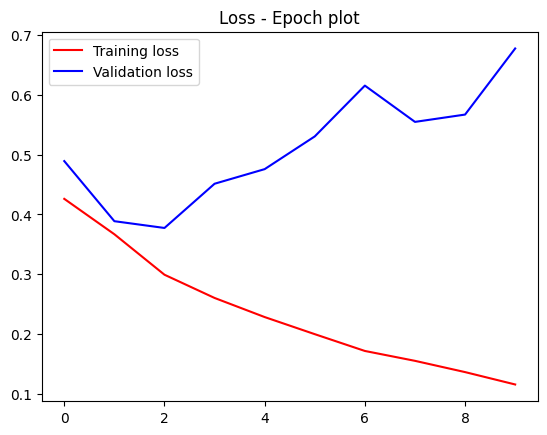

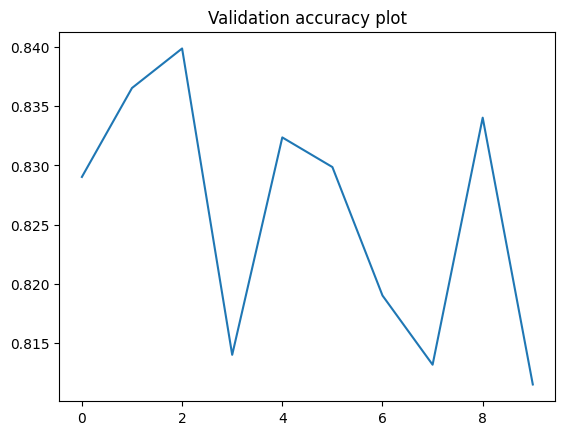

Running through test set: 100%|██████████| 63/63 [02:32<00:00,  2.42s/it]



Test accuracy:  tensor(0.8270)


In [ ]:
'''

from experiments.classification import Classification

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 64)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--max_iter', type=int, default=10)
parser.add_argument('--resize_size', type=int, default=224)
args = parser.parse_args(args=[])

classification = Classification()

classification.run_binary_classification_pipeline(args)


'''



In [ ]:
'''

#from experiments.segmentation import run_semantic_segmentation_pipeline
from experiments.evaluate import eval_segmentation
from common.utils import get_config

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--max_iter', type=int, default=5)
parser.add_argument('--resize_size', type=int, default=336)
parser.add_argument('--model_path', type=str, default='./models/checkpoints/resnet-18-best-1.pt')

args = parser.parse_args([])

cfg = get_config()

cod10k_res_path = f'{cfg["output_dir"]}/Test-SemSeg/COD10K'
cod10k_gt_path = f'{cfg["data_dir"]}/TestDataset/COD10K/GT'

camo_res_path = f'{cfg["output_dir"]}/Test-SemSeg/CAMO'
camo_gt_path = f'{cfg["data_dir"]}/TestDataset/CAMO/GT'


chameleon_res_path = f'{cfg["output_dir"]}/Test-SemSeg/CHAMELEON'
chameleon_gt_path = f'{cfg["data_dir"]}/TestDataset/CHAMELEON/GT'

#run_semantic_segmentation_pipeline(args, 'chameleon')
#print('\nEvaluage predicted segmentation masks on chameleon dataset\n')
#eval_segmentation(chameleon_res_path, chameleon_gt_path)

run_semantic_segmentation_pipeline(args, 'camo')
print('\nEvaluage predicted segmentation masks on camo dataset\n')
eval_segmentation(camo_res_path, camo_gt_path)

#run_semantic_segmentation_pipeline(args, 'cod10k')
#print('\nEvaluage predicted segmentation masks on cod10k dataset\n')
#eval_segmentation(cod10k_res_path, cod10k_gt_path)


'''

